In [1]:
from moleculAR.preprocessing import feature_preparation, descriptor_generation, smiles_cleaning
from moleculAR.training import regression_models

## Use MoleculAR

This NoteBook is an example for the use of the package. In this notebook the following steps will be followed in order to create a melting point predictor based on a molecule smile :

- Load a dataset
- Reduce the analyze to molecules containing a specific substructure (to reduce computation time for descriptors and training in this example notebook)
- Generate features : descriptors, or fingerprint
- Preprocess the features : remove low variance features, remove highly correlated features, handle NaN values in the features
- Evaluate different default models with a single function
- Plot predicted vs actual values for a given model


The BradleyMeltingPoint dataset will be use, let's load it :

In [2]:
# Load the dataset
import pandas as pd
raw_df = pd.read_excel("Data/BradleyMeltingPointDataset.xlsx")

As the dataset contains "donotuse" molecules we remove it :

In [3]:
# Drop row with a non-Nan value in the "donotuse" column
raw_df = raw_df[raw_df["donotuse"].isna()]
raw_df.head(5)

,key,name,smiles,mpC,csid,link,source,donotuse,donotusebecause
0,1,"2-(2,4-dinitrobenzyl)pyridine",c1ccnc(c1)Cc2ccc(cc2[N+](=O)[O-])[N+](=O)[O-],92.0,64018,http://www.alfa.com/en/GP100W.pgm?DSSTK=B24192,Alfa Aesar,NaN,NaN
1,2,2-(1-piperidinyl)aniline,c1ccc(c(c1)N)N2CCCCC2,46.0,403764,http://www.alfa.com/en/GP100W.pgm?DSSTK=A13073,Alfa Aesar,NaN,NaN
2,3,2-(1-piperazinyl)pyrimidine,c1cnc(nc1)N2CCNCC2,33.0,80080,http://www.alfa.com/en/GP100W.pgm?DSSTK=L15884,Alfa Aesar,NaN,NaN
3,4,2-(1-piperazinyl)phenol,c1ccc(c(c1)N2CCNCC2)O,125.0,63701,http://www.alfa.com/en/GP100W.pgm?DSSTK=B20252,Alfa Aesar,NaN,NaN
4,5,2-(1-cyclohexenyl)ethylamine,C1CCC(=CC1)CCN,-55.0,69388,http://www.alfa.com/en/GP100W.pgm?DSSTK=L08261,Alfa Aesar,NaN,NaN


Now, we remove non valid smiles using the clean_smiles_dataframe function of the package

In [4]:
# Select only valid and non-duplicate SMILES
clean_df = smiles_cleaning.clean_smiles_dataframe(raw_df, "smiles")
clean_df.shape

[10:13:25] Explicit valence for atom # 20 C, 5, is greater than permitted
[10:13:25] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
[10:13:25] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 23
[10:13:26] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[10:13:26] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[10:13:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[10:13:26] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
[10:13:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[10:13:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[10:13:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[10:13:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[10:13:26] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[10:13:26] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8
[10:13:26] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 8 9 10 11 12 13 14
[10:13:26] Can't kekulize mol.  Unkeku

Removed 8323 rows with invalid or duplicate SMILES.


/Users/malogfeller/git/Ppchem-MP-predictor/Malo/moleculAR/moleculAR/preprocessing/smiles_cleaning.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid_smiles.loc[:, 'canonical_smiles'] = df_valid_smiles[column].apply(canonical_smiles)


(19945, 9)

Only the smiles and melting point columns are needed. Let's select only those columns :

In [5]:
# Keep only smiles and melting point columns
clean_df = clean_df[["smiles", "mpC"]]
clean_df.shape

(19945, 2)

Now, in order to reduce the time of all following computation (descriptors, training for models, ...) we will keep only molecules containig Sulfonic Acid as substructure (arbitrary) using the keep_only_substructure function.

In [7]:
# Keep only molecules containing Sulfonic Acid as substructure
sulfonic_df = smiles_cleaning.keep_only_substructure(clean_df, "CS(=O)(=O)O", "smiles")
sulfonic_df.shape

(84, 2)

## Features extraction and training : mordred descriptors

We now need to add descriptors to our dataset. We have different option here, mordred descriptors or fringerprints. Let's do the first example with mordred descriptors. 
\\
\\
We can use the generate_mordred_columns to compute all mordred descriptors and add them to the dataframe. With large dataset, this function may take time to run.

In [8]:
# Generate Mordred features for the cyclobutane dataset
sulfonic_mordred_df = descriptor_generation.generate_mordred_columns(sulfonic_df, "smiles", ignore_3D = False)

We see that a column has been added for each descriptor and the value for each smile has been calculated.

In [9]:
sulfonic_mordred_df.head(10)

,smiles,mpC,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,Cc1ccc(cc1)S(=O)(=O)OC[C@H]2[C@@H](OC(O2)(C)C)...,90.0,NaN,NaN,0,0,37.685027,2.438918,4.802376,37.685027,...,10.398702,81.319188,470.106910,8.247490,2951,47,166.0,191.0,12.354167,6.444444
1,C1COS(=O)(=O)C1,32.0,NaN,NaN,0,0,8.128329,2.256190,4.345820,8.128329,...,8.543835,48.240889,122.003765,9.384905,39,4,34.0,36.0,3.062500,1.500000
2,Cc1ccc(cc1)S(=O)(=O)OCCCOS(=O)(=O)c2ccc(cc2)C,91.0,NaN,NaN,0,0,30.207447,2.353178,4.706355,30.207447,...,10.050743,59.561936,384.070130,8.534892,1820,36,126.0,142.0,9.819444,5.416667
3,CC1([C@H]2CC[C@@]1(C(=O)C2)CS(=O)(=O)O)C,200.0,NaN,NaN,1,0,17.339909,2.648977,5.069962,17.339909,...,10.223504,65.475893,232.076930,7.486353,309,25,88.0,109.0,7.409722,2.937500
4,Cc1ccc(cc1)S(=O)(=O)OCC(F)(F)F,40.0,NaN,NaN,0,0,18.140380,2.356250,4.712501,18.140380,...,9.583489,48.287518,254.022450,10.160898,460,20,80.0,87.0,7.847222,3.333333
5,C(C(F)(F)F)OS(=O)(=O)C(Cl)(Cl)Cl,-70.0,NaN,NaN,0,0,12.814087,2.361765,4.723531,12.814087,...,9.498897,44.444445,279.874233,18.658282,250,16,64.0,68.0,8.687500,2.562500
6,c1cc(c(cc1N)S(=O)(=O)O)N,299.0,NaN,NaN,1,0,13.726844,2.367582,4.735164,13.726844,...,9.397235,43.034658,188.025563,9.401278,183,16,60.0,67.0,6.145833,2.527778
7,CC#CCOS(=O)(=O)c1ccc(cc1)C,48.0,NaN,NaN,0,0,17.838517,2.343899,4.687798,17.838517,...,9.378478,46.469447,224.050715,8.298175,400,19,70.0,77.0,6.284722,3.458333
8,Cc1ccc(cc1)S(=O)(=O)OC2Cc3ccccc3C2,120.0,NaN,NaN,0,0,25.434012,2.428027,4.787671,25.434012,...,9.947744,67.839422,288.082015,8.002278,838,29,108.0,126.0,6.368056,4.236111
9,c1ccc2c(c1)C(=O)OS2(=O)=O,120.0,NaN,NaN,0,0,14.865606,2.491578,4.793398,14.865606,...,9.630169,58.310845,183.983030,11.498939,170,18,66.0,79.0,4.645833,2.513889


Using different functions from the package we can remove low variance and highly correlated features. Also, different methods for handling NaN values can be perform using the function handle_missing_data.

In [10]:
low_var_mordred_df = feature_preparation.remove_low_variance_features(sulfonic_mordred_df, ["mpC", "smiles"], threshold=0.05)
low_var_mordred_df.shape

/Users/malogfeller/anaconda3/envs/ppchem/lib/python3.10/site-packages/sklearn/feature_selection/_variance_threshold.py:111: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


(84, 988)

In [11]:
# Remove highly correlated features from the Mordred dataset
no_corr_mordred_df = feature_preparation.remove_highly_correlated(low_var_mordred_df, excluded_cols=["mpC", "smiles"], threshold=0.95)
no_corr_mordred_df

,mpC,smiles,nBase,ATS0dv,ATS1dv,ATS4dv,ATS5dv,ATS6dv,ATS7dv,ATS8dv,...,n9FARing,n9FAHRing,nRot,SLogP,TopoPSA,GGI2,GGI3,GGI4,Diameter,AMW
0,90.00,Cc1ccc(cc1)S(=O)(=O)OC[C@H]2[C@@H](OC(O2)(C)C)...,0.0,470.888889,306.333333,513.333333,569.333333,590.666667,536.444444,339.333333,...,0.0,0.0,8.0,2.93434,121.96,5.555556,3.013889,1.654444,17.0,8.247490
1,32.00,C1COS(=O)(=O)C1,0.0,120.444444,33.333333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,-0.26350,51.75,0.888889,0.444444,0.000000,3.0,9.384905
2,91.00,Cc1ccc(cc1)S(=O)(=O)OCCCOS(=O)(=O)c2ccc(cc2)C,0.0,366.888889,201.333333,356.000000,265.333333,292.444444,137.333333,356.000000,...,0.0,0.0,8.0,2.80434,103.50,4.222222,1.875000,1.084444,16.0,8.534892
3,200.00,CC1([C@H]2CC[C@@]1(C(=O)C2)CS(=O)(=O)O)C,0.0,208.444444,128.666667,204.000000,255.000000,0.000000,0.000000,0.000000,...,0.0,0.0,2.0,1.26960,79.82,3.777778,2.743056,1.311111,5.0,7.486353
4,40.00,Cc1ccc(cc1)S(=O)(=O)OCC(F)(F)F,0.0,344.444444,188.666667,204.666667,444.666667,176.000000,144.000000,88.000000,...,0.0,0.0,3.0,2.26262,51.75,2.666667,1.000000,0.982222,9.0,10.160898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,137.00,O=C(Sc1ccc(cc1)OS(C)(=O)=O)NC,0.0,246.888889,152.000000,196.666667,166.666667,122.444444,75.333333,64.666667,...,0.0,0.0,3.0,1.45650,106.15,1.333333,1.000000,0.862222,10.0,9.667146
80,113.00,CC(C)(C)S(=O)(=O)O,0.0,116.444444,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.67270,62.75,2.000000,0.000000,0.000000,3.0,7.668615
81,30.10,O=S(=O)(OCC)c2cccc1OCC(C)(C)c12,0.0,246.444444,170.666667,290.666667,269.000000,37.000000,13.000000,0.000000,...,1.0,1.0,3.0,2.08180,60.98,3.333333,2.381944,1.323889,7.0,7.759907
82,104.85,O=S(=O)(Oc1cccc(N)c1)c2ccc(cc2)C,0.0,254.444444,186.666667,284.333333,248.666667,208.000000,106.000000,70.000000,...,0.0,0.0,3.0,2.34492,77.77,2.444444,1.500000,1.004444,10.0,8.485859


In [12]:
# Handle NaN values in the Mordred dataset
final_df = feature_preparation.handle_missing_data(no_corr_mordred_df, excluded_cols=["smiles", "mpC"], threshold=0.2, fill_method='mean')
final_df

,smiles,mpC,nBase,ATS0dv,ATS1dv,ATS4dv,ATS5dv,ATS6dv,ATS7dv,ATS8dv,...,n9FARing,n9FAHRing,nRot,SLogP,TopoPSA,GGI2,GGI3,GGI4,Diameter,AMW
0,Cc1ccc(cc1)S(=O)(=O)OC[C@H]2[C@@H](OC(O2)(C)C)...,90.00,0.0,470.888889,306.333333,513.333333,569.333333,590.666667,536.444444,339.333333,...,0.0,0.0,8.0,2.93434,121.96,5.555556,3.013889,1.654444,17.0,8.247490
1,C1COS(=O)(=O)C1,32.00,0.0,120.444444,33.333333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,-0.26350,51.75,0.888889,0.444444,0.000000,3.0,9.384905
2,Cc1ccc(cc1)S(=O)(=O)OCCCOS(=O)(=O)c2ccc(cc2)C,91.00,0.0,366.888889,201.333333,356.000000,265.333333,292.444444,137.333333,356.000000,...,0.0,0.0,8.0,2.80434,103.50,4.222222,1.875000,1.084444,16.0,8.534892
3,CC1([C@H]2CC[C@@]1(C(=O)C2)CS(=O)(=O)O)C,200.00,0.0,208.444444,128.666667,204.000000,255.000000,0.000000,0.000000,0.000000,...,0.0,0.0,2.0,1.26960,79.82,3.777778,2.743056,1.311111,5.0,7.486353
4,Cc1ccc(cc1)S(=O)(=O)OCC(F)(F)F,40.00,0.0,344.444444,188.666667,204.666667,444.666667,176.000000,144.000000,88.000000,...,0.0,0.0,3.0,2.26262,51.75,2.666667,1.000000,0.982222,9.0,10.160898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,O=C(Sc1ccc(cc1)OS(C)(=O)=O)NC,137.00,0.0,246.888889,152.000000,196.666667,166.666667,122.444444,75.333333,64.666667,...,0.0,0.0,3.0,1.45650,106.15,1.333333,1.000000,0.862222,10.0,9.667146
80,CC(C)(C)S(=O)(=O)O,113.00,0.0,116.444444,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.67270,62.75,2.000000,0.000000,0.000000,3.0,7.668615
81,O=S(=O)(OCC)c2cccc1OCC(C)(C)c12,30.10,0.0,246.444444,170.666667,290.666667,269.000000,37.000000,13.000000,0.000000,...,1.0,1.0,3.0,2.08180,60.98,3.333333,2.381944,1.323889,7.0,7.759907
82,O=S(=O)(Oc1cccc(N)c1)c2ccc(cc2)C,104.85,0.0,254.444444,186.666667,284.333333,248.666667,208.000000,106.000000,70.000000,...,0.0,0.0,3.0,2.34492,77.77,2.444444,1.500000,1.004444,10.0,8.485859


## Train
Our dataset is now featurized and cleaned. The training can be done. First, feature and target are separated :

In [13]:
X = final_df.drop(columns=["smiles", "mpC"])
y = final_df["mpC"]

The first test for different models with default parameters can easily be done using the compare_regression_model function. This function is a nice way to get an idea of wich regression models are relevant for our task.

In [14]:
# Compare regression models
regression_models.compare_regression_models(X, y)

,R2 Score,RMSE
LightGBM,0.676081,52.342796
Random Forest,0.658670,53.731156
Gradient Boosting,0.638221,55.317257
XGBoost,0.305643,76.635506
Linear Regression,-27.229905,488.645021


The top 3 models are LightLGBM, GradientBoosting and RandomForest. We can easily plot the test result *predicted vs actual* with the plot_predictions function.

R² Score: 0.6424
RMSE: 54.9942


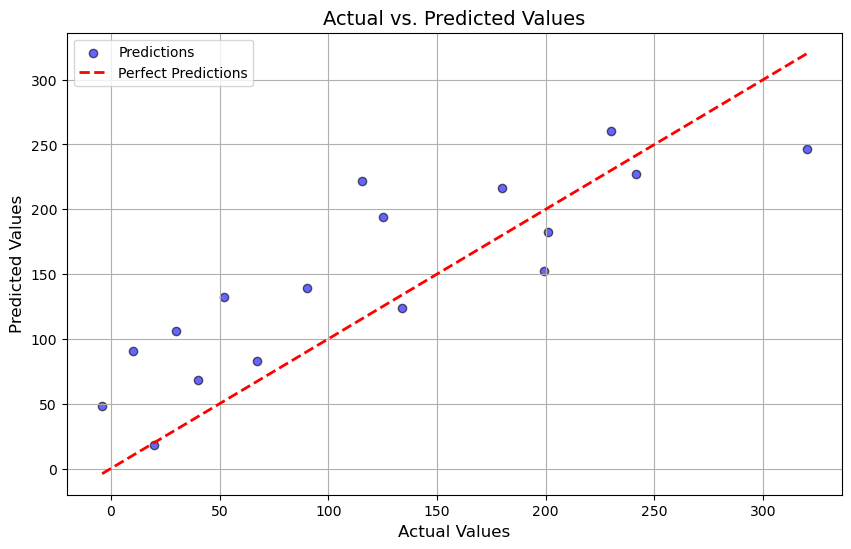

R² Score: 0.6714
RMSE: 52.7171


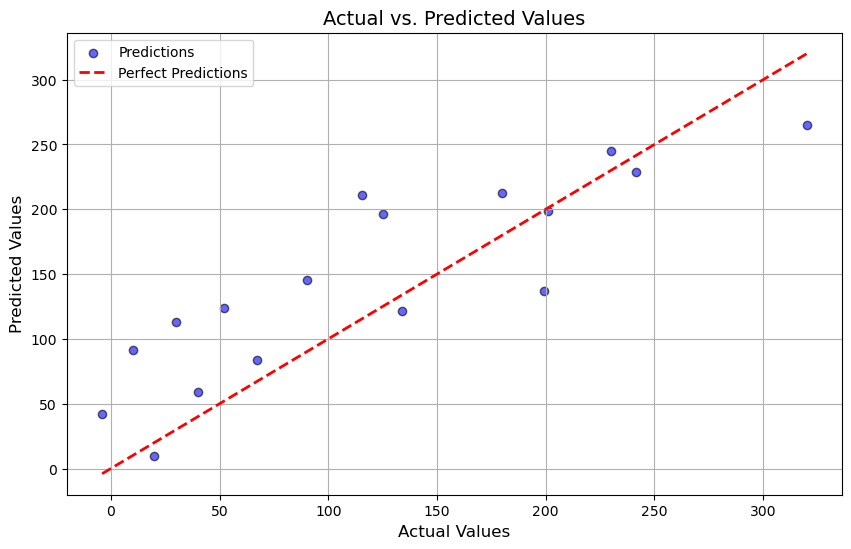

R² Score: 0.6474
RMSE: 54.6087


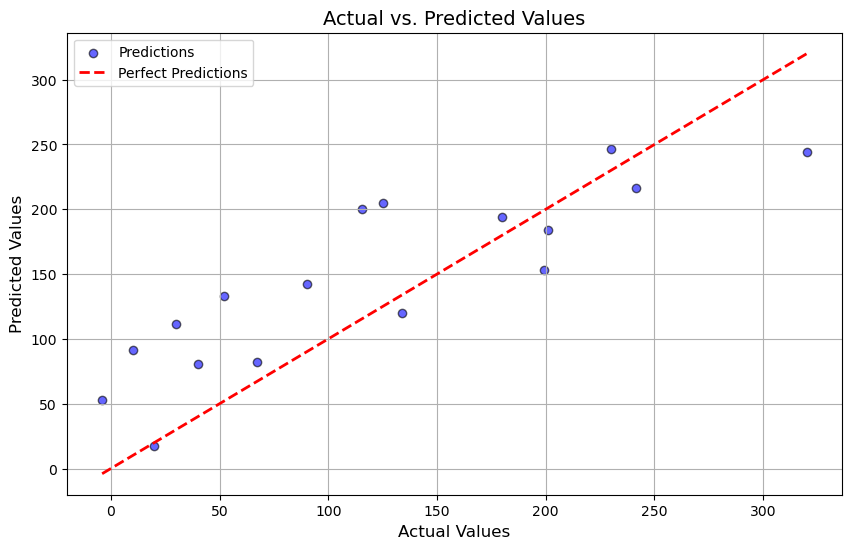

In [15]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Plot predictions using the best model (XGBoost) and Morgan fingerprints
best_model1 = RandomForestRegressor(n_estimators=100)
best_model2 = GradientBoostingRegressor()
best_model3 = LGBMRegressor()

regression_models.plot_predictions(best_model1, X, y)
regression_models.plot_predictions(best_model1, X, y)
regression_models.plot_predictions(best_model1, X, y)

## Features extraction and training : fingerprints

As said, the featurization using fingerprint is also possible using the generate_fingerprint_descriptors. It works the same than the mordred descriptors generation with now a fingerprint bit for each column. Three fingerprint types are supported : 'Morgan', 'MACCS', 'Topological'.

In [8]:
# Generate Morgan fingerprints for the cyclobutane dataset
morgan_fp_df = descriptor_generation.generate_fingerprint_descriptors(clean_df, "smiles", fingerprint_type='Morgan', n_bits=2048)
morgan_fp_df.shape

(19945, 2049)

In [17]:
morgan_fp_df

,Morgan_bit_0,Morgan_bit_1,Morgan_bit_2,Morgan_bit_3,Morgan_bit_4,Morgan_bit_5,Morgan_bit_6,Morgan_bit_7,Morgan_bit_8,Morgan_bit_9,...,Morgan_bit_2039,Morgan_bit_2040,Morgan_bit_2041,Morgan_bit_2042,Morgan_bit_2043,Morgan_bit_2044,Morgan_bit_2045,Morgan_bit_2046,Morgan_bit_2047,smiles
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Cc1ccc(cc1)S(=O)(=O)OC[C@H]2[C@@H](OC(O2)(C)C)...
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,C1COS(=O)(=O)C1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Cc1ccc(cc1)S(=O)(=O)OCCCOS(=O)(=O)c2ccc(cc2)C
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,CC1([C@H]2CC[C@@]1(C(=O)C2)CS(=O)(=O)O)C
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Cc1ccc(cc1)S(=O)(=O)OCC(F)(F)F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,O=C(Sc1ccc(cc1)OS(C)(=O)=O)NC
80,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,CC(C)(C)S(=O)(=O)O
81,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,O=S(=O)(OCC)c2cccc1OCC(C)(C)c12
82,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,O=S(=O)(Oc1cccc(N)c1)c2ccc(cc2)C


As before, we can now evaluate different models :

In [19]:
# Train and evaluate models using Morgan fingerprints
X_fgp = morgan_fp_df.drop(columns=['smiles'])
y_fgp = sulfonic_df['mpC']

regression_models.compare_regression_models(X_fgp, y_fgp)

,R2 Score,RMSE
XGBoost,0.620931,56.623640
Linear Regression,0.606613,57.683090
Random Forest,0.524804,63.397935
Gradient Boosting,0.508089,64.503323
LightGBM,0.081613,88.135656


As before, we can plot the different result for the top 3 models :

R² Score: 0.6209
RMSE: 56.6236


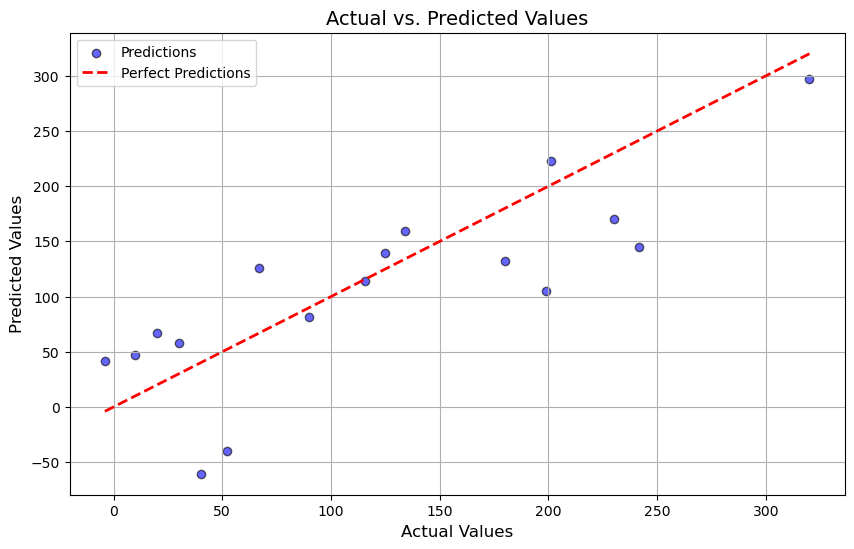

R² Score: 0.6066
RMSE: 57.6831


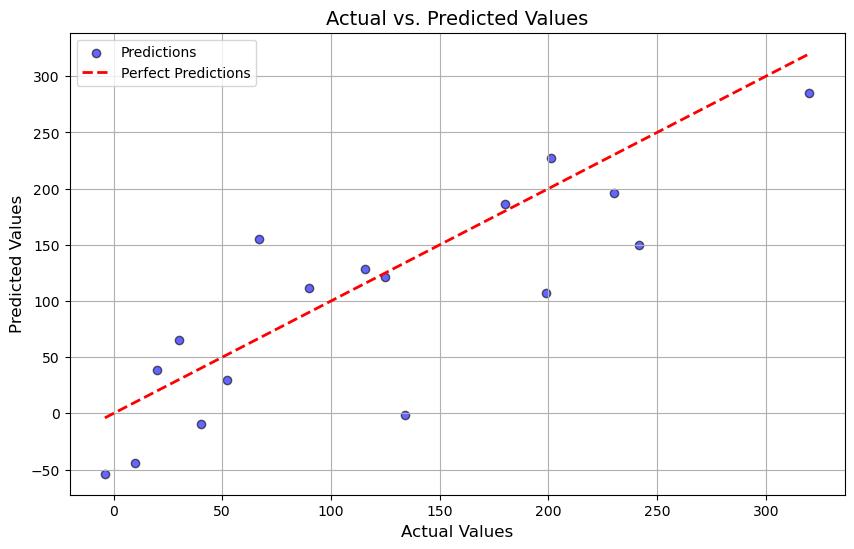

R² Score: 0.5556
RMSE: 61.3126


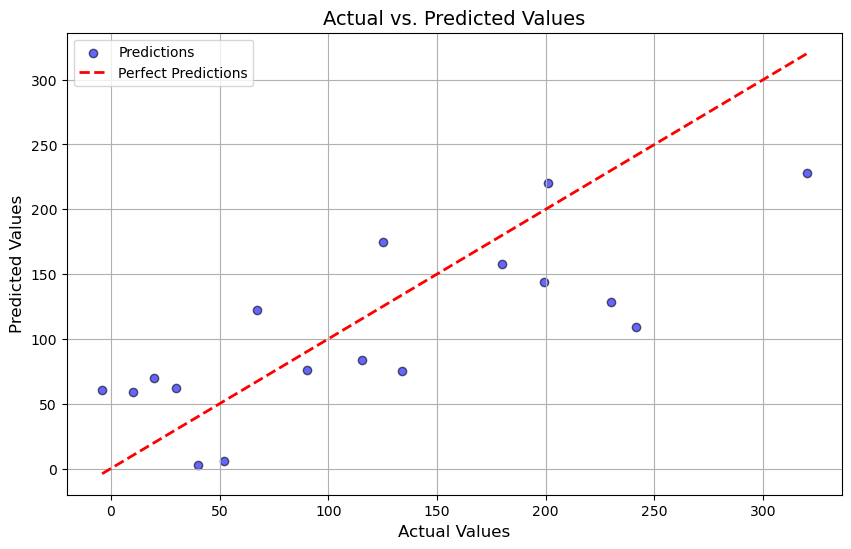

In [20]:
# Plot predictions using the best models with fingerprint dataset
best_model1_fgp = XGBRegressor()
best_model2_fgp = LinearRegression()
best_model3_fgp = RandomForestRegressor()

regression_models.plot_predictions(best_model1_fgp, X_fgp, y_fgp)
regression_models.plot_predictions(best_model2_fgp, X_fgp, y_fgp)
regression_models.plot_predictions(best_model3_fgp, X_fgp, y_fgp)